<a href="https://colab.research.google.com/github/1324-niyati/demopygit/blob/master/ALY6110_Lab1_VirmaniN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Prepare your Google Colab PySpark Session:

# Install PySpark in Google Colab
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("BostonHousingPCA").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f43742a30883369e2f7ed110a1b9e18bb32b13c002155bf6a047d2703418dcd5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
# 2. Read 'BostonHousing.csv' dataset in PySpark:

# Load the dataset
data = spark.read.csv("BostonHousing-1.csv", header=True, inferSchema=True)
data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [5]:
# 3. Combine features to a single vector column using VectorAssembler (all columns other than target column 'medv'):

# Combine features into a single vector
feature_columns = data.columns[:-1]  # Exclude the target column 'medv'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data)

In [6]:
# 4. Standardize features for principal component analysis:

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)

In [7]:
# 5. Train model for two principal component analysis:

# Perform PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(data_scaled)
data_pca = pca_model.transform(data_scaled)
data_pca.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|      scaledFeatures|         pcaFeatures|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[7.34751712931429...|[-1.2551263234672...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[0.00317501096205...|[-1.8955383642584...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[0.00317268579840...|[-1.2788028017576...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[0.00376327736

In [8]:
# 6. Collect distributed data in numpy array and then convert to pandas dataframe:
# Convert to Pandas DataFrame for plotting
pca_features = np.array(data_pca.select("pcaFeatures").rdd.map(lambda row: row[0]).collect())
pca_df = pd.DataFrame(pca_features, columns=["PCA1", "PCA2"])

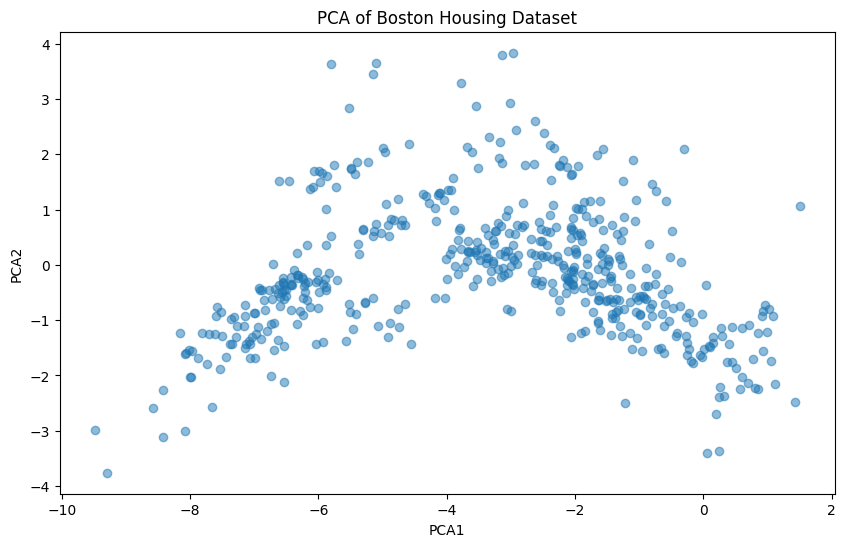

In [9]:
# 7. Plot two principal components:
# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PCA1"], pca_df["PCA2"], alpha=0.5)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA of Boston Housing Dataset")
plt.show()

In [10]:
# 8. Vectorize features and target together for model development:
# Prepare features and target for linear regression
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_vectorized = assembler.transform(data)
final_data = data_vectorized.select("features", data["medv"].alias("label"))

In [11]:
#9. Split dataset into training and testing dataset:
# Split the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [12]:
# 10. Fit model for linear regression:
# Fit linear regression model
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

In [13]:
# 11. Find out model coefficients and intercept:
# Get the model coefficients and intercept
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.11362203729409111,0.048909186934055354,0.023795428986748923,2.801771998735071,-18.415424541191168,3.5158797633118337,0.005211682161471176,-1.4163830723540525,0.3317669315937271,-0.013607893704165114,-0.953414333840846,0.008602677392852453,-0.5195035312476768]
Intercept: 38.616991445737995


In [14]:
# 12. Evaluate model for test dataset:
# Evaluate the model on test data
test_results = lr_model.evaluate(test_data)
print("RMSE: ", test_results.rootMeanSquaredError)
print("R2: ", test_results.r2)

RMSE:  4.671806485171298
R2:  0.7931522547835954


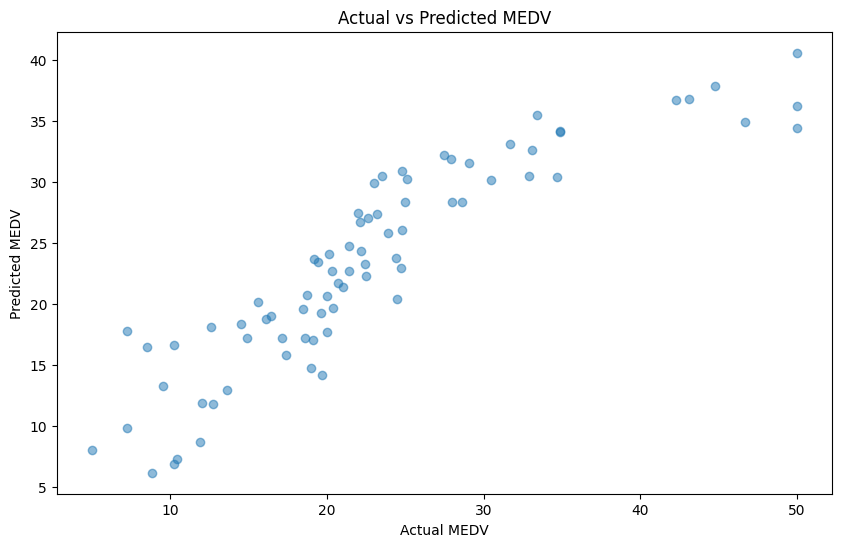

In [15]:
# 13. Perform further analysis for better interpretation of model results:
# Further analysis (e.g., plotting predicted vs actual values)
predictions = lr_model.transform(test_data)
predictions_df = predictions.select("prediction", "label").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_df["label"], predictions_df["prediction"], alpha=0.5)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted MEDV")
plt.show()